# CLIMB+CLIFF at high-resolution on BeatAML dataset 

Here we used deconvoluted cell-type proportions and deconvoluted expression at high-resolution yielded by CLIMB, as input for CLIFF. CLIFF then output a prediction of cell-type drug sensitivity for each patient, each cell-type and each drug. 

In [2]:
library(glmnet) ; library(ggplot2) ; library(reshape2)
library(CoreGx) ; library(PharmacoGx) ; library(climb)
library(sigmoid); library(ComplexHeatmap) ; library(circlize)
library(ggrepel); library(ggpmisc) ; library(infotheo)
# We load CLIFF library
library(cliff)

In [3]:
# METRICS FUNCTIONS
num <- function(x){ return(as.numeric(as.character(x)))}
flatten <- function(x){return(as.vector(as.matrix(x)))}

In [63]:
detach("package:climb", unload=TRUE)
devtools::install_github('alexdray86/climb', force=T)
library(climb)


── R CMD build ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
✔  checking for file ‘/private/var/folders/z6/0fzn0d4s1v74_s44tjrc9mg00000gp/T/RtmpLKUYlW/remotes15b0f23f538e1/alexdray86-CLIMB-80a4315/DESCRIPTION’
─  preparing ‘climb’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘climb_0.0.5.tar.gz’
   



Attaching package: ‘climb’


The following objects are masked _by_ ‘.GlobalEnv’:

    bulk.es, sc.es




In [1063]:
detach("package:cliff", unload=TRUE)
devtools::install_github('alexdray86/cliff-R', force=T)
library(cliff)

── R CMD build ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
✔  checking for file ‘/private/var/folders/z6/0fzn0d4s1v74_s44tjrc9mg00000gp/T/Rtmp6n99hN/remotes102ed2926f64a/alexdray86-cliff-R-90b6258/DESCRIPTION’ (401ms)
─  preparing ‘cliff’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘cliff_0.0.1.2.tar.gz’
   


## Launch CLIMB at high-resolution on BeatAML dataset 

In [64]:
# Load single-cell reference dataset
sc.es = readRDS('data/pseudobulks_climb/AML_vangalen_sc_es.RDS')

In [65]:
celltype_names = levels(sc.es$cellType)

In [66]:
# Load BeatAML bulk samples
bulk.es = readRDS("data/aml_3cohorts/beatAML_bulk_es_451s.RDS")

In [67]:
# Load BeatAML metadata - contains mutation data
beataml_meta = read.csv('data/beataml_drug/beatAML_metadata451.tsv', sep = '\t')

In [68]:
all(rownames(beataml_meta) == colnames(bulk.es))

[1] TRUE

In [69]:
### RUN CLIMB in expression mode to deconvolute proportions + high-resolution cell-type expression ### 

## WARNING: This takes around >12 hours to run ##
## One can alternatively load the CLIMB output on next cell ##

climb_out = climb(sc.es, bulk.es, mode='expression', cancer_pattern = 'like')
saveRDS(climb_out, 'data/beataml_drug/climb_out_expression_beatamlALL451_final.RDS')

EXPRESSION mode: predicting cell-type expression in bulks - requires single-cell coefficients fitted by CLIMB

6606 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance / expression

Cell-type abundance prediction done. 

Starting high-resolution expression deconvolution

High-Resolution expression prediction: 1000 genes processed...

High-Resolution expression prediction: 2000 genes processed...

High-Resolution expression prediction: 3000 genes processed...

High-Resolution expression prediction: 4000 genes processed...

High-Resolution expression prediction: 5000 genes processed...

High-Resolution expression prediction: 6000 genes processed...



In [73]:
### Load pre-processed deconvoluted CLIMB's proportions and expression
climb_out = readRDS('data/beataml_drug/climb_out_expression_beatamlALL451_final.RDS')

In [74]:
all(rownames(beataml_meta) == dimnames(climb_out$expr.highres)[[1]])

[1] TRUE

## Compute AUC for all drugs / patients 

We compute AUC values for each drug/patient to be used as input for CLIFF. Wu use AUC values from cell viability as a proxy for cell viability.

Hereafter, we load the raw drug sensitivity data and compute AUC from it using `computeAUC` from `PharmacoGx` library. Warning: `computeAUC` returns AUC related to (1-Viability) as stated in the [doc](https://rdrr.io/bioc/PharmacoGx/man/computeAUC.html), we thus use (1-AUC) to have a score related to cell viability.

Warning: This computation takes a long time! (about 2 hours) Alternatively, one can use the pre-processed data in the next cell.

In [75]:
drug_raw_beataml = read.csv('data/beataml_drug/drug_beataml_raw.csv')
head(drug_raw_beataml)

,drug_name,sample_id,dose.0.0137,dose.0.0412,dose.0.1235,dose.0.3704,dose.1.1111,dose.3.3333,dose.10
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A-674563,11-00261,NA,NA,NA,NA,NA,NA,NA
2,A-674563,11-00487,1.0712105,0.8456925,1.3633588,0.7431843,0.6099237,0.09225737,0.00000000
3,A-674563,12-00066,0.5941722,0.8200558,0.7648125,0.4775475,0.5057829,0.13749439,0.09575502
4,A-674563,12-00069,0.8150066,0.7651083,0.8071279,0.6968263,0.4867279,0.19346560,0.07791149
5,A-674563,12-00109,1.0599386,0.9049974,0.5141230,0.7007567,0.6268076,0.48595188,0.49299469
6,A-674563,12-00127,1.5189696,0.7991101,0.8651522,0.5085246,0.5745667,0.40946136,0.29058548


In [16]:
# Compute AUC from raw drug sensitivity values
drug_raw_beataml = drug_raw_beataml[!apply(drug_raw_beataml, 1, function(x) any(is.na(x))),]
raw_viability = as.matrix(drug_raw_beataml[,3:9])
melt_drug_raw_beataml = melt(drug_raw_beataml)
melt_drug_raw_beataml$variable = num(gsub('dose\\.','',melt_drug_raw_beataml$variable))
doses = num(unique(melt_drug_raw_beataml$variable))                                           

Using drug_name, sample_id as id variables



In [17]:
melt_drug_raw_beataml$uniq_id = paste0(melt_drug_raw_beataml$drug_name, '_', melt_drug_raw_beataml$sample_id)

In [18]:
computeAUC_ = function(viability){
    # computeAUC returns AUC related to (1-viability), we thus use (1-x)
    computeAUC(doses, viability, conc_as_log = FALSE, viability_as_pct=FALSE, area.type = 'Fitted', trunc = FALSE, verbose = FALSE)
}                                      
drug_beataml_auc = aggregate(melt_drug_raw_beataml$value, list(melt_drug_raw_beataml$uniq_id), computeAUC_)

In [ ]:
colnames(drug_beataml_auc) = c('uniq_id', 'auc')
rownames(drug_beataml_auc) = drug_beataml_auc$uniq_id
drug_beataml_auc$drug = gsub('_.*', '', drug_beataml_auc$uniq_id)
drug_beataml_auc$sample = gsub('.*_', '', drug_beataml_auc$uniq_id)

In [ ]:
write.csv(drug_beataml_auc, 'data/beataml_drug/drug_beataml_auc_sensitivity.csv',quote=F)

In [12]:
# Load pre-processed AUC values for BeatAML dataset
drug_beataml_auc = read.csv('data/beataml_drug/drug_beataml_auc_sensitivity.csv', row.names='X')

In [1041]:
drug_beataml_auc.bma = drug_beataml_auc[drug_beataml_auc$sample %in% rownames(beataml_meta)[bma.sel],]

## Process and compute somatic mutation matrix from metadata

In [ ]:
mut.data = beataml_meta[,87:158]
mut.data = apply(mut.data, 2, function(x) gsub('positive', '1', x))
mut.data = apply(mut.data, 2, function(x) gsub('negative', NA, x))
mut.data = apply(mut.data, 2, function(x) gsub('..*', '1', x))
mut.data = apply(mut.data, 2, function(x) gsub('^$', '0', x))            
mut.data[is.na(mut.data)] <- 0
mut.data = apply(mut.data, 2, function(x) num(x))              
# Select mutation that spans at least 5 patients
sel.mutation = colSums(mut.data) > 5
mut.data = mut.data[,sel.mutation]
rownames(mut.data) = rownames(beataml_meta)

In [190]:
write.csv(mut.data, 'data/beataml_drug/mutation_data.csv', quote=F)

In [13]:
# load pre-processed mutation data
mut.data = as.matrix(read.csv('data/beataml_drug/mutation_data.csv', row.names='X'))

In [21]:
mut.data.bma = mut.data[bma.sel,]

## CLIFF-highres on beatAML - example with Venetoclax

CLIFF runs with one drug at a time. We can begin with venetoclax drug as an example. In the next chapter, we run all drugs simulteneously.

In [76]:
this_drug = 'Venetoclax'
drug_beataml_auc_ = drug_beataml_auc[drug_beataml_auc$drug == this_drug,]
#drug_beataml_auc_ = data.frame(sample=colnames(auc_values), auc=num(auc_values[this_drug,]))
rownames(drug_beataml_auc_) = drug_beataml_auc_$sample

# find intersecting samples 
inter_sample = Reduce(intersect, list(rownames(drug_beataml_auc_), colnames(bulk.es), rownames(mut.data)))

# Intersect drug and bulk data
bulk.es.sub = bulk.es[,inter_sample]
drug_beataml_auc_sub = drug_beataml_auc_[inter_sample,]
mut.data.sub = mut.data[inter_sample,]

# intersect genes for bulk expression
bulk.es.sub = bulk.es.sub[rownames(bulk.es.sub) %in% dimnames(climb_out$expr.highres)[[2]],]

# Feature Selection 
bulk_mat = t(exprs(bulk.es.sub))
drug_data = drug_beataml_auc_sub$auc
sel.genes = cliff_gene_selection(bulk_mat, drug_data, min.genes=50)
filter.genes = dimnames(climb_out$expr.highres)[[2]] %in% sel.genes

In [77]:
# Subset CLIMB output
climb_res.filt = climb_out
climb_res.filt$expr.highres = climb_res.filt$expr.highres[,filter.genes,]
climb_res.filt$expr.mapping = climb_res.filt$expr.mapping[,filter.genes,]
climb_res.filt$expr.overall = climb_res.filt$expr.overall[filter.genes,]

In [78]:
cliff.out = cliff(climb_res.filt, drug_beataml_auc_, mut.data, min.mutation=5, mode='overall', 
                  regularization='L2', max.em.steps = 200)
PI = cliff.out[[1]]
mut.data.out = cliff.out[[2]]
climb_prop = cliff.out[[3]]

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 15



In [79]:
col_fun_props = colorRamp2(c(0, 0.08, 0.15, 0.25, 0.4), rev(c("#00004d", "#002366", "grey58", "grey88", "white")))
ha = HeatmapAnnotation(NPM1 = as.character(mut.data.out[,'NPM1']), FLT3.ITD = as.character(mut.data.out[,'FLT3.ITD']),
                       DNMT3A = as.character(mut.data.out[,'DNMT3A']),IDH2 = as.character(mut.data.out[,'IDH2']),
                       `HSC-like content` = climb_prop[,'HSC-like'],`Prog-like content` = climb_prop[,'Prog-like'],
                       `Mono-like content` = climb_prop[,'Mono-like'],
                       col = list(`HSC-like content`=col_fun_props, `Prog-like content`=col_fun_props,`Mono-like content`=col_fun_props,
                                  NPM1=c('0' = "white", '1' = "#00004d"), FLT3.ITD=c('0' = "white", '1' = "#00004d"),
                                  DNMT3A=c('0' = "white", '1' = "#00004d"),IDH2=c('0' = "white", '1' = "#00004d")),
                       simple_anno_size = unit(0.39, "cm"),
                       show_legend = c(F,F,F,F,F,F,F))
ra = rowAnnotation(`Drug Sensitivity` = anno_boxplot(PI[,order(colMeans(PI))], width = unit(3.8, "cm")), gp = gpar(fill = 1:2))
quant = quantile(flatten(as.matrix(PI)), probs=c(0,0.05,0.5,0.95,1))# ; quant[3] = 0.5
options(repr.plot.width=11, repr.plot.height=4.9)
#col_fun = colorRamp2(c(0,0.25,0.5,0.75,1), rev(c("darkred", "red", "white", "cornflowerblue", "darkblue")))
col_fun = colorRamp2(c(quant[1], quant[2], quant[3], quant[4], quant[5]), rev(c("darkred", "red", "white", "cornflowerblue", "darkblue")))
h <- Heatmap(t(PI)[order(colMeans(PI)),], name = "Predicted Drug Sensitivity", col=col_fun, show_column_names = F, bottom_annotation = ha, left_annotation=ra, 
             cluster_rows=F, show_column_dend = F, show_row_dend=F, column_title=paste0('Predicted drug sensitivity for ', dim(PI)[1], ' patients after ',this_drug, ' treatment'))
#pdf(paste0('../REVISION_2/results/fig5/heatmap_',this_drug,'_highres_drugPred.pdf'), width=11, height=4.9) ; h ; dev.off()

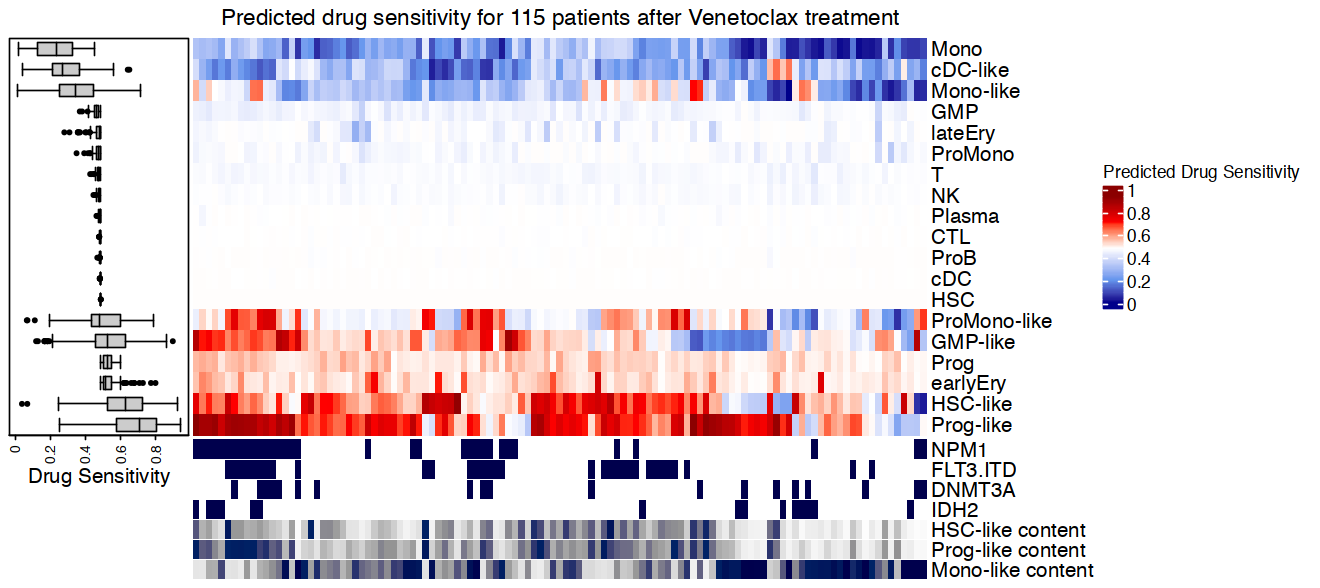

In [80]:
h

In [91]:
2/28

[1] 0.07142857

## Iterate over all drugs

In [87]:
drug_beataml_auc_full = read.csv('data/beataml_drug/drug_beataml_auc_sensitivity.csv', row.names='X')
list_drugs = unique(drug_beataml_auc$drug)
mutation_data_full = as.matrix(read.csv('data/beataml_drug/mutation_data.csv', row.names='X'))
climb_out_full = readRDS('data/beataml_drug/climb_out_expression_beatamlALL451.RDS')

In [88]:
list_drugs

[1] "A-674563"      "ABT-737"       "AT7519"        "AZD1480"      
  [5] "Afatinib"      "Alisertib"     "Axitinib"      "BEZ235"       
  [9] "BI-2536"       "BMS-345541"    "Barasertib"    "Bay"          
 [13] "Bortezomib"    "Bosutinib"     "CHIR-99021"    "CI-1040"      
 [17] "CYT387"        "Cabozantinib"  "Canertinib"    "Cediranib"    
 [21] "Crenolanib"    "Crizotinib"    "DBZ"           "Doramapimod"  
 [25] "Dovitinib"     "Elesclomol"    "Entospletinib" "Entrectinib"  
 [29] "Erlotinib"     "Flavopiridol"  "Foretinib"     "GDC-0879"     
 [33] "GDC-0941"      "GSK-1838705A"  "GSK-1904529A"  "GSK690693"    
 [37] "GW-2580"       "Gefitinib"     "Gilteritinib"  "Go6976"       
 [41] "Ibrutinib"     "Idelalisib"    "Imatinib"      "JAK"          
 [45] "JNJ-28312141"  "JNJ-38877605"  "JNJ-7706621"   "JQ1"          
 [49] "KI20227"       "KU-55933"      "KW-2449"       "LY-333531"    
 [53] "Lapatinib"     "Lenalidomide"  "Lenvatinib"    "Linifanib"    
 [57] "Lovastatin"    "MGCD-265"      "MK-2206"       "MLN8054"      
 [61] "Masitinib"     "Midostaurin"   "Motesanib"     "NF-kB"        
 [65] "NVP-ADW742"    "NVP-TAE684"    "Neratinib"     "Nilotinib"    
 [69] "Nutlin"        "PD173955"      "PHA-665752"    "PHT-427"      
 [73] "PI-103"        "PLX-4720"      "PP242"         "PRT062607"    
 [77] "Palbociclib"   "Panobinostat"  "Pazopanib"     "Pelitinib"    
 [81] "Quizartinib"   "RAF265"        "Rapamycin"     "Regorafenib"  
 [85] "Roscovitine"   "Ruxolitinib"   "S31-201"       "SB-431542"    
 [89] "SGX-523"       "SNS-032"       "SR9011"        "STO609"       
 [93] "SU11274"       "Saracatinib"   "Selinexor"     "Selumetinib"  
 [97] "Sorafenib"     "Staurosporine" "TG100-115"     "TG101348"     
[101] "Tandutinib"    "Tanespimycin"  "Tivozanib"     "Tofacitinib"  
[105] "Tozasertib"    "Trametinib"    "VX-745"        "Vandetanib"   
[109] "Vargetef"      "Vatalanib"     "Vemurafenib"   "Venetoclax"   
[113] "Vismodegib"    "Volasertib"    "XAV-939"

In [1092]:
avg_celltype = list()
all_bulk_pcc = list() ; all_bulk_cor_pval = list()
for(d in 1:length(list_drugs)){
    this_drug = list_drugs[[d]]
    message(this_drug)
    # load drug data for the specific compound
    #drug_beataml_auc_ = drug_beataml_auc[drug_beataml_auc$drug == this_drug,]
    drug_beataml_auc_ = drug_beataml_auc.bma[drug_beataml_auc.bma$drug == this_drug,]
    rownames(drug_beataml_auc_) = drug_beataml_auc_$sample
    
    # Filter genes 
    # Intersect drug and bulk data
    inter_ = intersect(colnames(bulk.es), drug_beataml_auc_$sample) 
    bulk.es.sub = bulk.es[,inter_]
    drug_beataml_auc_sub = drug_beataml_auc_[inter_,]

    # Gene selection 
    bulk.es.sub = bulk.es.sub[rownames(bulk.es.sub) %in% dimnames(climb_out$expr.highres)[[2]],]
    # Feature Selection 
    bulk_mat = t(exprs(bulk.es.sub))
    drug_data = drug_beataml_auc_sub$auc
    sel.genes = cliff_gene_selection(bulk_mat, drug_data, min.genes=50)
    filter.genes = dimnames(climb_out$expr.highres)[[2]] %in% sel.genes
    
    # Subset CLIMB output
    climb_res.filt = climb_out
    climb_res.filt$expr.highres = climb_res.filt$expr.highres[,filter.genes,]
    climb_res.filt$expr.mapping = climb_res.filt$expr.mapping[,filter.genes,]
    climb_res.filt$expr.overall = climb_res.filt$expr.overall[filter.genes,]
    
    # Launch CLIFF
    cliff.out = cliff(climb_res.filt, drug_beataml_auc_, mut.data, min.mutation=5, mode='overall', 
                      max.em.steps = 200, regularization='L2')
    PI = cliff.out[[1]]
    mut.data.out = cliff.out[[2]]
    climb_prop = cliff.out[[3]]
    
    drug_beataml_auc_sub = drug_beataml_auc_[rownames(drug_beataml_auc_) %in% rownames(mut.data.out),]
    bulk_pcc = cor(rowSums(cliff.out[[1]] * climb_prop), drug_beataml_auc_sub$auc)
    message(paste0('Bulk PCC for drug ', this_drug, ': ', bulk_pcc))
    cor_test = cor.test(rowSums(cliff.out[[1]] * climb_prop), drug_beataml_auc_sub$auc)
    message(paste0('Correlation p-value for drug ', this_drug, ': ', cor_test$p.value))
    all_bulk_pcc[[d]] = bulk_pcc
    all_bulk_cor_pval[[d]] = cor_test$p.value
    
    if(mean(var(PI)) == 0){ next }
    
    # Save result
    write.csv(PI, paste('results/fig6/tab_all_drugs/PI_', this_drug,'.csv'))
    avg_celltype[[d]] = colMeans(PI)
    # Make Plot 
    col_fun_props = colorRamp2(c(0, 0.08, 0.15, 0.25, 0.4), rev(c("#00004d", "#002366", "grey58", "grey88", "white")))
    if(all(c('NPM1', 'FLT3.ITD', 'IDH2', 'DNMT3A') %in% colnames(mut.data.out))){
        ha = HeatmapAnnotation(NPM1 = as.character(mut.data.out[,'NPM1']), FLT3.ITD = as.character(mut.data.out[,'FLT3.ITD']),
                           DNMT3A = as.character(mut.data.out[,'DNMT3A']),IDH2 = as.character(mut.data.out[,'IDH2']),
                           `HSC-like content` = climb_prop[,'HSC-like'],`Prog-like content` = climb_prop[,'Prog-like'],
                           `Mono-like content` = climb_prop[,'Mono-like'],
                           col = list(`HSC-like content`=col_fun_props, `Prog-like content`=col_fun_props,`Mono-like content`=col_fun_props,
                                      NPM1=c('0' = "white", '1' = "#00004d"), FLT3.ITD=c('0' = "white", '1' = "#00004d"),
                                      DNMT3A=c('0' = "white", '1' = "#00004d"),IDH2=c('0' = "white", '1' = "#00004d")),
                           simple_anno_size = unit(0.39, "cm"),
                           show_legend = c(F,F,F,F,F,F,F))        
    } else {
        ha = HeatmapAnnotation(`HSC-like content` = climb_prop[,'HSC-like'],`Prog-like content` = climb_prop[,'Prog-like'],
                           `Mono-like content` = climb_prop[,'Mono-like'],
                           col = list(`HSC-like content`=col_fun_props, `Prog-like content`=col_fun_props,`Mono-like content`=col_fun_props,
                                      NPM1=c('0' = "white", '1' = "#00004d"), FLT3.ITD=c('0' = "white", '1' = "#00004d"),
                                      DNMT3A=c('0' = "white", '1' = "#00004d"),IDH2=c('0' = "white", '1' = "#00004d")),
                           simple_anno_size = unit(0.39, "cm"),
                           show_legend = c(F,F,F))      
    }
    ra = rowAnnotation(`Drug Sensitivity` = anno_boxplot(PI, width = unit(3.8, "cm")), gp = gpar(fill = 1:2))
    quant = quantile(flatten(as.matrix(PI)), probs=c(0,0.05,0.5,0.95,1))
    options(repr.plot.width=11, repr.plot.height=4.9)
    col_fun = colorRamp2(c(quant[1], quant[2], quant[3], quant[4], quant[5]), rev(c("darkred", "red", "white", "cornflowerblue", "darkblue")))
    h <- Heatmap(t(PI), name = "Predicted Sensitivity", col=col_fun, show_column_names = F, bottom_annotation = ha, left_annotation=ra, 
                 show_column_dend = F, show_row_dend=F, column_title=paste0('Predicted drug sensitivity for ', dim(PI)[1], ' patients after ',this_drug, ' treatment'))
    pdf(paste0('results/fig6/fig_all_drugs/heatmap_',this_drug,'_highres_drugPred.pdf'), width=11, height=4.9) ; print(h) ; dev.off()
}

A-674563

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 15

Bulk PCC for drug A-674563: 0.558627088441249

Correlation p-value for drug A-674563: 1.05531965218267e-08

ABT-737

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 13

Bulk PCC for drug ABT-737: 0.449966317713772

Correlation p-value for drug ABT-737: 4.5407135606944e-05

AT7519

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorith

Correlation p-value for drug Crizotinib: 5.10099247086153e-06

DBZ

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 10

Bulk PCC for drug DBZ: 0.706225333763454

Correlation p-value for drug DBZ: 1.00790489336099e-10

Doramapimod

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 13

Bulk PCC for drug Doramapimod: 0.544767155455404

Correlation p-value for drug Doramapimod: 3.40824392230654e-08

Dovitinib

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algor

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 15

Bulk PCC for drug JAK: 0.539324341870062

Correlation p-value for drug JAK: 4.14438442079807e-08

JNJ-28312141

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 12

Bulk PCC for drug JNJ-28312141: 0.536791318689659

Correlation p-value for drug JNJ-28312141: 1.41251461579722e-07

JNJ-38877605

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 10

Bulk PCC for drug JNJ-38877605: 0.538372242923955

Correlation p-value for drug JNJ-38877605: 5.27810110391388e-08

JNJ-7706621

Prepare CLIFF inp

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 12

Bulk PCC for drug NVP-TAE684: 0.557906514594737

Correlation p-value for drug NVP-TAE684: 2.39734378352366e-08

Neratinib

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 12

Bulk PCC for drug Neratinib: 0.43393545659908

Correlation p-value for drug Neratinib: 2.40340894261636e-05

Nilotinib

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 7

Bulk PCC for drug Nilotinib: 0.464110562779151

Correlation p-val

SB-431542

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 12

Bulk PCC for drug SB-431542: 0.659015338569959

Correlation p-value for drug SB-431542: 1.23355926309993e-12

SGX-523

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

Bulk PCC for drug SGX-523: 0.380987958397301

Correlation p-value for drug SGX-523: 0.000321660370197532

SNS-032

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algo

Bulk PCC for drug Vargetef: 0.474943717483273

Correlation p-value for drug Vargetef: 3.35181394304056e-06

Vatalanib

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 10

Bulk PCC for drug Vatalanib: 0.574781096257068

Correlation p-value for drug Vatalanib: 3.85266668137922e-09

Vemurafenib

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 12

Bulk PCC for drug Vemurafenib: 0.640978478511183

Correlation p-value for drug Vemurafenib: 8.84345811670454e-09

Venetoclax

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Prepare CLIFF input from CLIMB outp

We select drus with a significant correlation between predicted AUC and true AUC:

In [1137]:
sel.drugs = num(all_bulk_cor_pval) < 0.05

In [1138]:
sum(sel.drugs)

[1] 115

## Load all results and compute average drug sensitivity for all drugs

In [1139]:
list_files = list.files('results/fig6/tab_all_drugs/')
list_files = list_files[!grepl('old', list_files)]
drug_names = gsub(' .csv','',gsub('PI_','',list_files))

In [1140]:
celltype_names = colnames(read.csv(paste0('results/fig6/tab_all_drugs/',list_files[[1]]), row.names='X'))

In [1149]:
avg_celltype = list() ; scale_celltype = list()
n_elements = 0 ; uniq_patients = c()
for(d in 1:length(list_files)){
    PI_mat = as.matrix(read.csv(paste0('results/fig6/tab_all_drugs/',list_files[[d]]), row.names='X'))
    avg_celltype[[d]] = num(colMeans(PI_mat))
    scale_celltype[[d]] = num(scale(avg_celltype[[d]])[,1])
    n_elements = n_elements + num(dim(PI_mat)[1])*num(dim(PI_mat)[2])
    uniq_patients = unique(union(uniq_patients, rownames(PI_mat)))
}

In [1150]:
length(uniq_patients)

[1] 204

In [1143]:
n_elements

[1] 344318

In [1098]:
avg_mat = do.call(rbind, avg_celltype)
scale_mat = do.call(rbind, scale_celltype)

In [1099]:
avg_mat = avg_mat[sel.drugs,sel.celltype]
scale_mat = scale_mat[sel.drugs,sel.celltype]

In [1100]:
colnames(avg_mat) = celltype_names[sel.celltype] ; rownames(avg_mat) = drug_names[sel.drugs]
colnames(scale_mat) = celltype_names[sel.celltype] ; rownames(scale_mat) = drug_names[sel.drugs]

In [1101]:
avg_mat = avg_mat[apply(scale_mat, 1, function(x) sum(is.na(x))) == 0 ,]
scale_mat = scale_mat[apply(scale_mat, 1, function(x) sum(is.na(x))) == 0 ,]

In [1103]:
h = Heatmap(t(scale_mat))
h <- draw(h)
row_h = row_order(h)
col_h = column_order(h)

In [1104]:
scale_mat_m = melt(scale_mat)
avg_mat_m = melt(avg_mat)

In [1105]:
colnames(scale_mat_m) = c('drug', 'celltype', 'z(auc)')
colnames(avg_mat_m) = c('drug', 'celltype', 'auc')

In [1106]:
scale_mat_m$drug = factor(scale_mat_m$drug, levels=rownames(scale_mat)[rev(col_h)])
scale_mat_m$celltype = gsub('\\.','-',scale_mat_m$celltype)
scale_mat_m$celltype = factor(scale_mat_m$celltype, levels=gsub('\\.','-',colnames(scale_mat))[row_h])
scale_mat_m$bulk_pcc = num(all_bulk_pcc)[sel.drugs]

In [1107]:
avg_mat_m$drug = factor(avg_mat_m$drug, levels=rownames(scale_mat)[rev(col_h)])
avg_mat_m$celltype = factor(avg_mat_m$celltype, levels=colnames(scale_mat)[row_h])
avg_mat_m$bulk_pcc = num(all_bulk_pcc)[sel.drugs]

In [1108]:
mat_m = cbind(scale_mat_m, avg_mat_m)[,c(1,2,3,4, 7)]

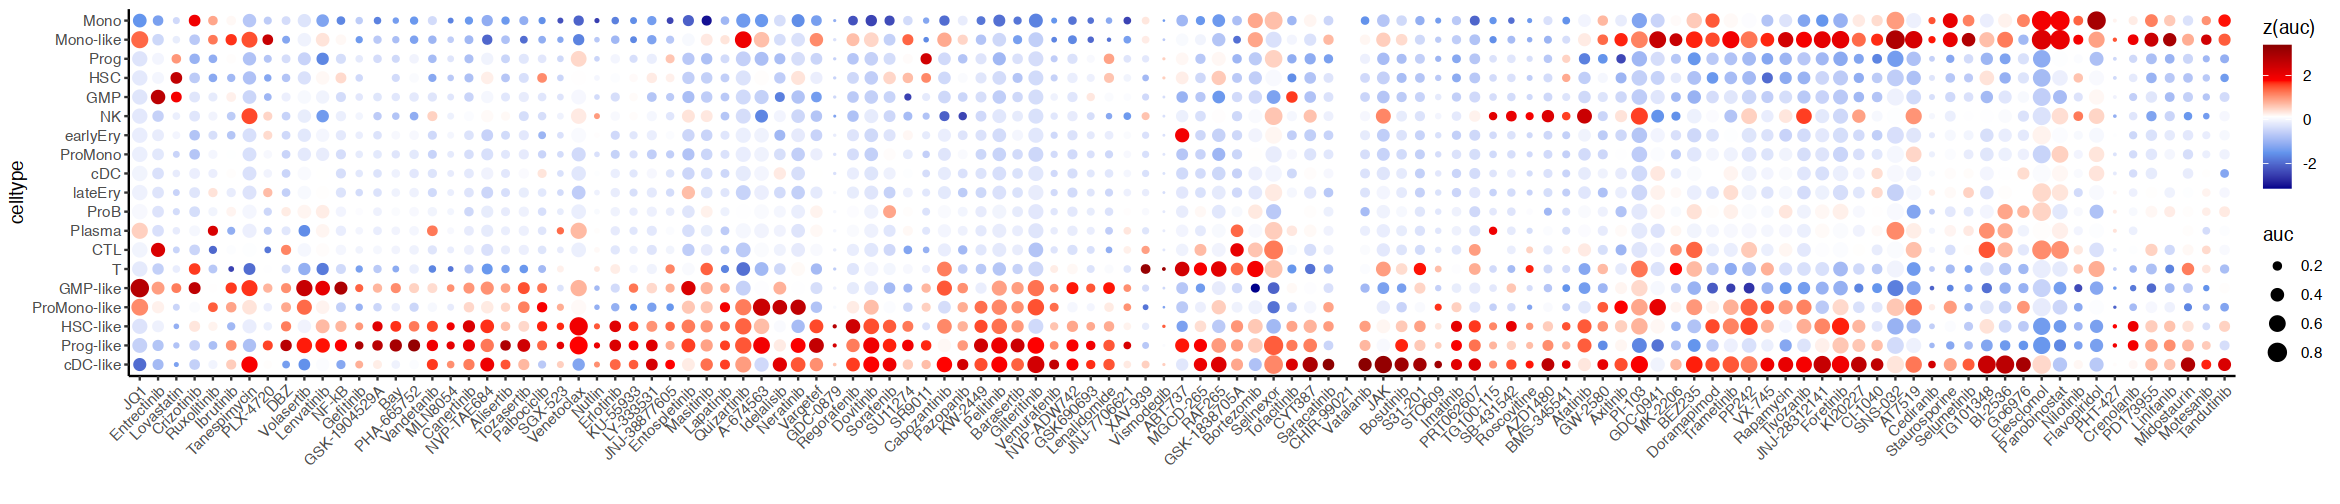

In [1109]:
options(repr.plot.width=19.5, repr.plot.height=4.2)
g <- ggplot(mat_m) + geom_point(aes(x=drug, y=celltype, color=`z(auc)`, size=auc)) +
    scale_colour_gradientn(colours = rev(c('darkred', 'red',  'white', 'cornflowerblue', 'darkblue'))) + 
    scale_size_continuous(range = c(-1, 4.5)) + xlab('')  + theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))# + theme_classic()
#pdf('results/fig6/heatmap_avg_celltype_drug_sensitivity_overall_2.pdf', width=18.5, height=4.3) ; g ; dev.off()
g

## Analysis of drug sensitivity for specific cell types of interest

In [1110]:
mat_m_hsclike = mat_m[mat_m$celltype == 'HSC-like',]
mat_m_hsclike$z_noneg = mat_m_hsclike$`z(auc)`-min(mat_m_hsclike$`z(auc)`)
mat_m_hsclike$score_hsclike = mat_m_hsclike$z_noneg*(mat_m_hsclike$auc)

In [1111]:
top20_hsc = head(mat_m_hsclike[order(-1*num(mat_m_hsclike$score_hsclike)),], 10)
top20_hsc$`HSC-like score` = top20_hsc$score_hsclike
top20_hsc$drug = factor(top20_hsc$drug, levels = as.character(top20_hsc$drug))
top20_hsc_high = top20_hsc

top20_hsc = head(mat_m_hsclike[order(num(mat_m_hsclike$score_hsclike)),], 10)
top20_hsc = top20_hsc[order(-1*num(top20_hsc$score_hsclike)),]
top20_hsc$`HSC-like score` = top20_hsc$score_hsclike
top20_hsc$drug = factor(top20_hsc$drug, levels = as.character(top20_hsc$drug))
top20_hsc_low = top20_hsc

top20_hsc = rbind(top20_hsc_high,  top20_hsc_low)

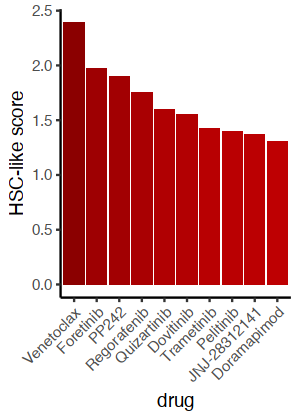

In [1112]:
options(repr.plot.width=2.5, repr.plot.height=3.5)
g <- ggplot(top20_hsc_high) + geom_col(aes(x=drug, y=`HSC-like score`, fill=`HSC-like score`)) + 
    scale_fill_gradient2(high='darkred', mid='red', low='red') + theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1.0, hjust=1),legend.position="none") #+ ylim(c(0,2.0))
#pdf('results/fig6/hsclike_top10_high.pdf', width=2.5, height=3.5) ; g ; dev.off()
g

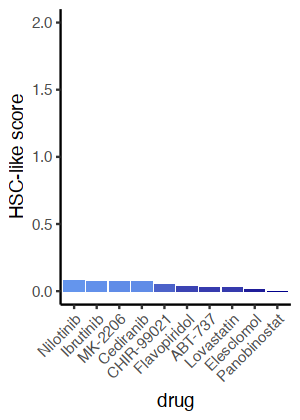

In [1113]:
options(repr.plot.width=2.5, repr.plot.height=3.5)
g <- ggplot(top20_hsc_low) + geom_col(aes(x=drug, y=`HSC-like score`, fill=`HSC-like score`)) + 
    scale_fill_gradient2(high='cornflowerblue', mid='darkblue', low='darkblue') + theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1.0, hjust=1),legend.position="none") + ylim(c(0,2.0))
#pdf('results/fig6/hsclike_top10_low.pdf', width=2.5, height=3.5) ; g ; dev.off()
g

In [1114]:
# add labels to top 15 drugs
mat_m_hsclike$label = ''
mat_m_hsclike[order(-1*num(mat_m_hsclike$score_hsclike)),][1:7,]$label <- as.character(mat_m_hsclike[order(-1*num(mat_m_hsclike$score_hsclike)),][1:7,]$drug)

In [1115]:
mat_m_hsclike$`HSC-like score` = mat_m_hsclike$score_hsclike

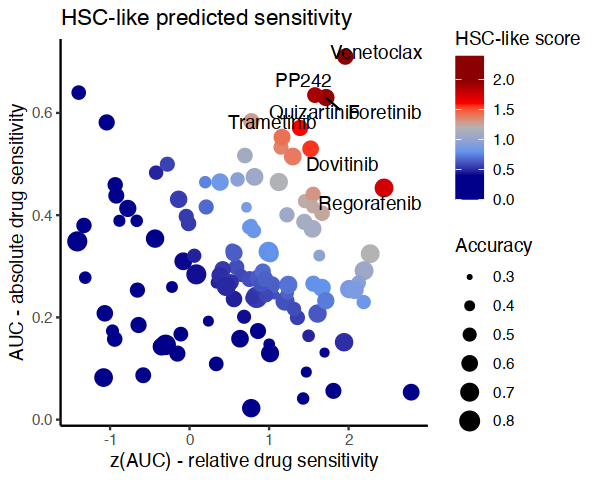

In [1116]:
options(repr.plot.width=5, repr.plot.height=4)
g <- ggplot(mat_m_hsclike) + geom_point(aes(x=`z(auc)`, y=auc, color=`HSC-like score`, size=bulk_pcc)) +
    geom_text_repel(aes(x=`z(auc)`, y=auc, label=label)) + 
    scale_size_continuous(range = c(-1,5), name='Accuracy') +
    scale_colour_gradientn(colours = rev(c('darkred', 'darkred',  'red', 'grey70', 'cornflowerblue', 'darkblue', 'darkblue'))) +
    xlab('z(AUC) - relative drug sensitivity') + ylab('AUC - absolute drug sensitivity') + ggtitle('HSC-like predicted sensitivity') + 
    theme_classic()
#pdf('results/fig6/dotplot_hsclike_specificity.pdf', width=5, height=4) ; g ; dev.off()
g

Same analysis for Prog-like and Mono-like cells 

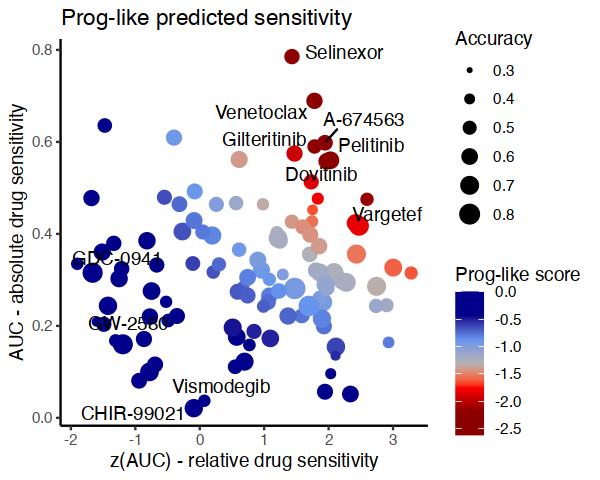

In [1117]:
mat_m_proglike = mat_m[mat_m$celltype == 'Prog-like',]
mat_m_proglike$z_noneg = mat_m_proglike$`z(auc)`-min(mat_m_proglike$`z(auc)`)
mat_m_proglike$score_proglike = mat_m_proglike$z_noneg*(mat_m_proglike$auc)
# add labels to top 15 sensitive drugs and top 10 resistant
mat_m_proglike$label = ''
mat_m_proglike[order(num(mat_m_proglike$score_proglike)),][1:4,]$label <- as.character(mat_m_proglike[order(num(mat_m_proglike$score_proglike)),][1:4,]$drug)
mat_m_proglike[order(num(mat_m_proglike$score_proglike)),][(dim(mat_m_proglike)[1]-6):dim(mat_m_proglike)[1],]$label <- as.character(mat_m_proglike[order(num(mat_m_proglike$score_proglike)),][(dim(mat_m_proglike)[1]-6):dim(mat_m_proglike)[1],]$drug)
mat_m_proglike$`Prog-like score` = -1*mat_m_proglike$score_proglike
options(repr.plot.width=5, repr.plot.height=4)
g <- ggplot(mat_m_proglike) + geom_point(aes(x=`z(auc)`, y=auc, color=`Prog-like score`, size=bulk_pcc)) +
    geom_text_repel(aes(x=`z(auc)`, y=auc, label=label)) + 
    scale_size_continuous(range = c(-1,5), name='Accuracy') +    theme_classic() +
    scale_colour_gradientn(colours = c('darkred', 'darkred',  'red', 'grey70', 'cornflowerblue', 'darkblue', 'darkblue')) +
    xlab('z(AUC) - relative drug sensitivity') + ylab('AUC - absolute drug sensitivity') + ggtitle('Prog-like predicted sensitivity') 
#pdf('results/fig6/dotplot_proglike_specificity.pdf', width=5, height=4) ; g ; dev.off()
g

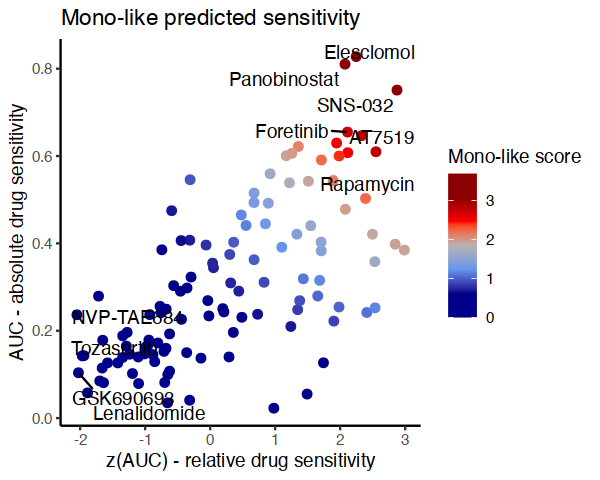

In [1118]:
mat_m_monolike = mat_m[mat_m$celltype == 'Mono-like',]
mat_m_monolike$z_noneg = mat_m_monolike$`z(auc)`-min(mat_m_monolike$`z(auc)`)
mat_m_monolike$score_monolike = mat_m_monolike$z_noneg*(mat_m_monolike$auc)
# add labels to top 15 sensitive drugs and top 10 resistant
mat_m_monolike$label = ''
mat_m_monolike[order(num(mat_m_monolike$score_monolike)),][1:4,]$label <- as.character(mat_m_monolike[order(num(mat_m_monolike$score_monolike)),][1:4,]$drug)
mat_m_monolike[order(num(mat_m_monolike$score_monolike)),][(dim(mat_m_monolike)[1]-10):dim(mat_m_monolike)[1],]$label <- as.character(mat_m_monolike[order(num(mat_m_monolike$score_monolike)),][(dim(mat_m_monolike)[1]-10):dim(mat_m_monolike)[1],]$drug)
mat_m_monolike$`Mono-like score` = mat_m_monolike$score_monolike
options(repr.plot.width=5, repr.plot.height=4)
g <- ggplot(mat_m_monolike) + geom_point(aes(x=`z(auc)`, y=auc, color=`Mono-like score`), size=2) +
    geom_text_repel(aes(x=`z(auc)`, y=auc, label=label)) + theme_classic() +
    scale_colour_gradientn(colours = rev(c('darkred', 'darkred',  'red', 'grey70', 'cornflowerblue', 'darkblue', 'darkblue')))+
    xlab('z(AUC) - relative drug sensitivity') + ylab('AUC - absolute drug sensitivity') + ggtitle('Mono-like predicted sensitivity')
#pdf('results/fig5/dotplot_monolike_specificity.pdf', width=5, height=4) ; g ; dev.off()
g

## Analysis of Cancer cells versus Normal cells

In [1119]:
score_mat = scale_mat * avg_mat
cancer_score = rowSums(score_mat[,grepl('like', colnames(score_mat))])
normal_score = rowSums(score_mat[,!grepl('like', colnames(score_mat))])
minmax <- function(x){ return((x - min(x))/(max(x) - min(x))) }
cancer_score = minmax(cancer_score)
normal_score = minmax(normal_score)
cancer_specificity = cancer_score*(1-normal_score)
df_cancer_spec = data.frame(cancer_score, normal_score, cancer_specificity)
df_cancer_spec$label = ''
df_cancer_spec[order(num(df_cancer_spec$cancer_specificity)),][1:10,]$label <- as.character(rownames(df_cancer_spec[order(num(df_cancer_spec$cancer_specificity)),][1:10,]))
df_cancer_spec[order(num(df_cancer_spec$cancer_specificity)),][(dim(df_cancer_spec)[1]-5):dim(df_cancer_spec)[1],]$label <- as.character(rownames(df_cancer_spec[order(num(df_cancer_spec$cancer_specificity)),][(dim(df_cancer_spec)[1]-5):dim(df_cancer_spec)[1],]))
df_cancer_spec$bulk_pcc = mat_m_hsclike$bulk_pcc

Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


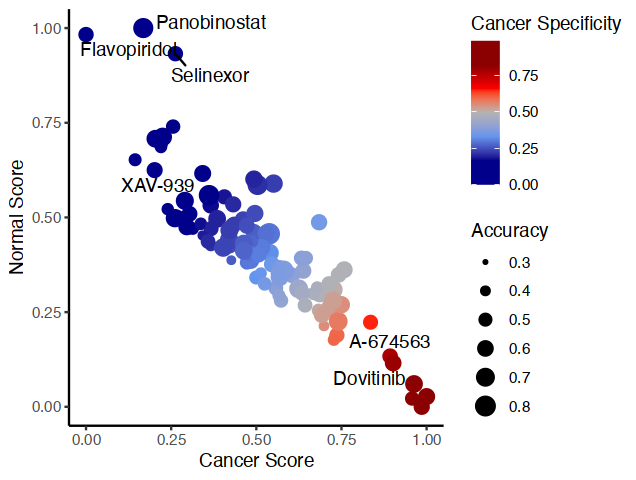

In [1120]:
options(repr.plot.width=5.3, repr.plot.height=4)
g <- ggplot(df_cancer_spec) + geom_point(aes(x=cancer_score, y=normal_score, color=cancer_specificity, size=bulk_pcc)) +
    scale_colour_gradientn(colours = rev(c('darkred', 'darkred',  'red', 'grey70', 'cornflowerblue', 'darkblue', 'darkblue')), name='Cancer Specificity') +
    geom_text_repel(aes(x=cancer_score, y=normal_score, label=label), max.overlaps = 5) + theme_classic() +
    scale_size_continuous(range = c(-1,5), name='Accuracy') +
    xlab('Cancer Score') + ylab('Normal Score') 
#pdf('results/fig6/dotplot_cancer_normal_specificity.pdf', width=5, height=4) ; g ; dev.off()
g

## Analysis of differentiated Myeloid versus undifferentiated cancer cells

In [1121]:
undiff_score = rowSums(score_mat[,c('HSC.like', 'Prog.like', 'HSC', 'Prog')])
diff_score = rowSums(score_mat[,c('Mono.like', 'ProMono.like', 'Mono')])
undiff_score = minmax(undiff_score)
diff_score = minmax(diff_score)
undiff_specificity = undiff_score*(1-diff_score)
df_undiff_spec = data.frame(undiff_score, diff_score, undiff_specificity)
df_undiff_spec$label = ''
df_undiff_spec$bulk_pcc = mat_m_hsclike$bulk_pcc
df_undiff_spec[order(num(df_undiff_spec$undiff_specificity)),][1:5,]$label <- as.character(rownames(df_undiff_spec[order(num(df_undiff_spec$undiff_specificity)),][1:5,]))
df_undiff_spec[order(num(df_undiff_spec$undiff_specificity)),][(dim(df_undiff_spec)[1]-5):dim(df_undiff_spec)[1],]$label <- as.character(rownames(df_undiff_spec[order(num(df_undiff_spec$undiff_specificity)),][(dim(df_undiff_spec)[1]-5):dim(df_undiff_spec)[1],]))


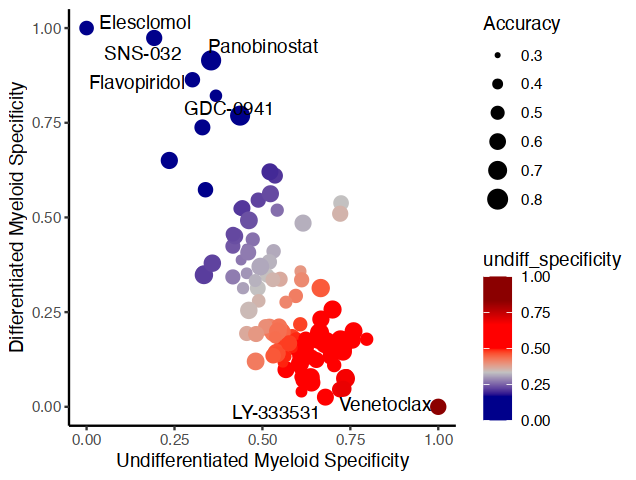

In [1122]:
g <- ggplot(df_undiff_spec) + geom_point(aes(x=undiff_score, y=diff_score, color=undiff_specificity, size=bulk_pcc)) +
    scale_size_continuous(range = c(-1,5), name='Accuracy') +
    scale_colour_gradientn(colours = rev(c('darkred', 'darkred',  'red', 'red', 'grey76', 'darkblue', 'darkblue'))) +
    geom_text_repel(aes(x=undiff_score, y=diff_score, label=label)) + theme_classic() +
    xlab('Undifferentiated Myeloid Specificity') + ylab('Differentiated Myeloid Specificity')
#pdf('results/fig6/dotplot_undiff_diff_specificity.pdf', width=5, height=4) ; g ; dev.off()
g

## Assemble both

In [1123]:
df_both = data.frame(Undifferentiated.Myeloid.Specificity= df_undiff_spec$undiff_specificity, 
                     Cancer.Cell.Specificity=df_cancer_spec$cancer_specificity,
                     HSC.like.Specificity= mat_m_hsclike$score_hsclike)

In [1124]:
df_both$score_ = df_both$Undifferentiated.Myeloid.Specificity*df_both$Cancer.Cell.Specificity
df_both$drug = mat_m_hsclike$drug
df_both$label = ''
df_both$bulk_pcc = mat_m_hsclike$bulk_pcc
df_both[order(num(df_both$score_)),][(dim(df_both)[1]-5):dim(df_both)[1],]$label <- as.character(df_both[order(num(df_both$score_)),][(dim(df_both)[1]-5):dim(df_both)[1],]$drug)

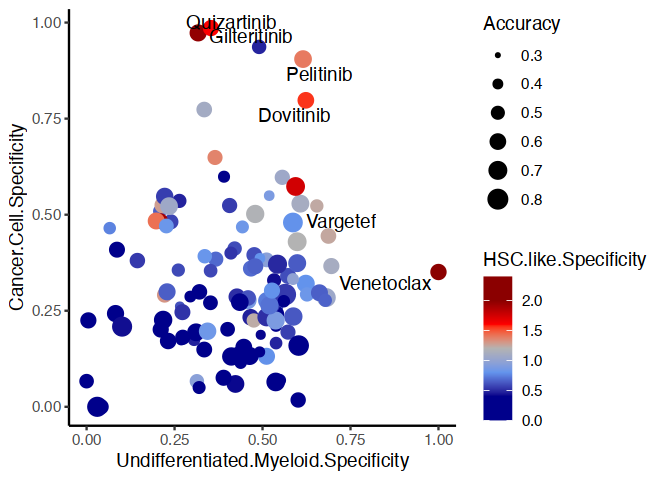

In [1125]:
options(repr.plot.width=5.5, repr.plot.height=4)
g <- ggplot(df_both) + geom_point(aes(x=`Undifferentiated.Myeloid.Specificity`, y=`Cancer.Cell.Specificity`, 
                                 color=`HSC.like.Specificity`, size=bulk_pcc)) + 
    scale_size_continuous(range = c(-1,5), name='Accuracy') +
    geom_text_repel(aes(x=`Undifferentiated.Myeloid.Specificity`, y=`Cancer.Cell.Specificity`,label=label)) +
    scale_colour_gradientn(colours = rev(c('darkred', 'darkred',  'red', 'grey70', 'cornflowerblue', 'darkblue', 'darkblue'))) +theme_classic()
#pdf('results/fig6/dotplot_undiff_cancer_hsclike_combined_specificity.pdf', width=5.5, height=4) ; g ; dev.off()
g

## Comparison with Bottomly et al.

In [1126]:
rownames(avg_mat) = gsub(' ','',rownames(avg_mat))

In [1127]:
bottomly = read.csv('data/beataml_drug/bottomly_drug_sens.csv')
bottomly_mat = dcast(bottomly, inhibitor ~ cell_type, value.var='cor')
rownames(bottomly_mat) = bottomly_mat$inhibitor
bottomly_mat = bottomly_mat[,-1]
rownames(bottomly_mat) = gsub('\\ .*','',rownames(bottomly_mat))
rownames(scale_mat) = gsub(' ', '',as.character(rownames(scale_mat)))
sel.drugs = intersect(as.character(rownames(bottomly_mat)), as.character(rownames(avg_mat)))

In [1128]:
bottomly_mat = as.matrix(bottomly_mat[sel.drugs,])
scale_mat_ = scale_mat[sel.drugs,]*-1
scale_mat_ = scale_mat_[,grepl('like', colnames(scale_mat_))]
colnames(scale_mat_) = gsub('\\.', '-',colnames(scale_mat_))
colnames(scale_mat_) = gsub('Mono-like', 'Monocyte-like',colnames(scale_mat_))
colnames(scale_mat_) = gsub('Prog-like', 'Progenitor-like',colnames(scale_mat_))
colnames(scale_mat_) = gsub('ProMonocyte-like', 'Promono-like',colnames(scale_mat_))
scale_mat_ = scale_mat_[,colnames(bottomly_mat)]
comp2bottomly = cbind(melt(scale_mat_), melt(bottomly_mat))[,c(1,2,3,6)]
colnames(comp2bottomly) = c('drug', 'celltype', 'CLIFF', 'Bottomly.cor')

pdf 
  2

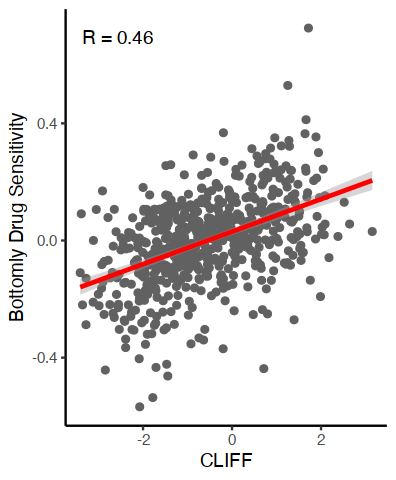

In [1152]:
options(repr.plot.width=3.3, repr.plot.height=4)
g <- ggplot(comp2bottomly, aes(x=CLIFF, y=Bottomly.cor),) + geom_point( color='grey38', size=1.5) + 
    stat_correlation() + stat_poly_line(formula = y ~ x, color = "red") + ylab('Bottomly Drug Sensitivity') +
    scale_colour_manual(values = rev(c('grey70', 'grey70',  'grey70', 'grey70', 'red', 'grey70'))) +theme_classic()
pdf('results/fig6/cor_with_bottomly.pdf', width=3.3, height=4) ; g ; dev.off()
g

In [1130]:
df_cor = data.frame(cor=diag(cor(t(scale_mat_), t(bottomly_mat))), drugs=sel.drugs)

In [1131]:
subset.drugs = c('Venetoclax', 'Foretinib', 'Sorafenib', 'AZD1480', 'Erlotinib', 
                                        'Selumetinib', 'Doramapimod', 'Midostaurin', 'Trametinib', 'Ruxolitinib', 
                                        'Selinexor', 'A-674563', 'Crenolanib', 'PI-103')
df_cor.sub = df_cor[df_cor$drugs %in% subset.drugs,]

In [1132]:
df_cor.sub$cor = num(df_cor.sub$cor)
df_cor.sub$drug = factor(df_cor.sub$drug, levels=df_cor.sub$drug[order(-1*df_cor.sub$cor)])

Warning message:
“Removed 1 rows containing missing values (`position_stack()`).”


pdf 
  2

Warning message:
“Removed 1 rows containing missing values (`position_stack()`).”


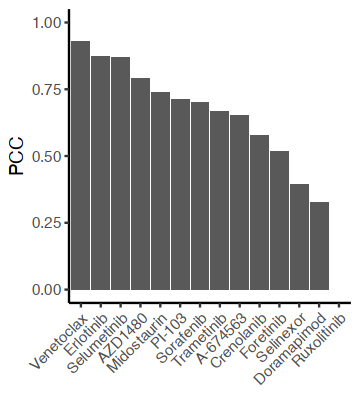

In [1151]:
options(repr.plot.width=3, repr.plot.height=3.5)
g <- ggplot(df_cor.sub) + geom_col(aes(x=drug, y=num(cor))) + theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1.0, hjust=1),legend.position="none") +
    xlab('') + ylab('PCC') +ylim(c(0,1))
pdf('results/fig6/subset_drugs_cor_bottomly.pdf', width=3, height=3.5) ; g ; dev.off()
g

## Compare mutation and cell-type drug sensitivity

In [1135]:
list_mat_p = list() ; list_mat_t = list()
for(d in 1:length(list_files)){
    PI_mat = as.matrix(read.csv(paste0('results/fig6/tab_all_drugs/',list_files[[d]]), row.names='X'))
    matrix_t = matrix(0, nrow=dim(mut.data_)[2], ncol=19)
    matrix_p = matrix(0, nrow=dim(mut.data_)[2], ncol=19)
    for(m in 1:dim(mut.data_)[2]){
        for(k in 1:19){
            if(sum(mut.data_[,m] == 1) < 2 | sum(mut.data_[,m] == 0) < 2){
                matrix_t[m,k] = 1
                matrix_p[m,k] = 1
            } else {
                matrix_t[m,k] = num(t.test(PI_mat[,k][mut.data_[,m] == 1], PI_mat[,k][mut.data_[,m] == 0])$statistic)
                matrix_p[m,k] = num(t.test(PI_mat[,k][mut.data_[,m] == 1], PI_mat[,k][mut.data_[,m] == 0])$p.value)
            }
        }    
    }
    
}

ERROR: Error in t.test.default(PI_mat[, k][mut.data_[, m] == 1], PI_mat[, k][mut.data_[, : not enough 'x' observations


In [255]:
list_files[grepl("Foretinib", list_files)]

[1] "PI_ Foretinib .csv"

In [256]:
PI_mat = as.matrix(read.csv(paste0('results/fig5/tab_all_drugs/',list_files[grepl("Foretinib", list_files)]), row.names='X'))

In [257]:
mut.data_ = mut.data[rownames(PI_mat),]

In [258]:
mean(PI_mat[,13][mut.data_[,1] == 1])

[1] 0.5237113

In [259]:
mean(PI_mat[,13][mut.data_[,1] == 0])

[1] 0.5271317

In [260]:
t_ = t.test(PI_mat[,k][mut.data_[,m] == 1], PI_mat[,k][mut.data_[,m] == 0])

In [261]:
t_$p.value

[1] 0.3244123

In [262]:
matrix_t = matrix(0, nrow=dim(mut.data_)[2], ncol=19)
matrix_p = matrix(0, nrow=dim(mut.data_)[2], ncol=19)
for(m in 1:dim(mut.data_)[2]){
    for(k in 1:19){
        if(sum(mut.data_[,m] == 1) < 2 | sum(mut.data_[,m] == 0) < 2){
            matrix_t[m,k] = 1
            matrix_p[m,k] = 1
        } else {
            matrix_t[m,k] = num(t.test(PI_mat[,k][mut.data_[,m] == 1], PI_mat[,k][mut.data_[,m] == 0])$statistic)
            matrix_p[m,k] = num(t.test(PI_mat[,k][mut.data_[,m] == 1], PI_mat[,k][mut.data_[,m] == 0])$p.value)
        }
    }
    
}   

The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.



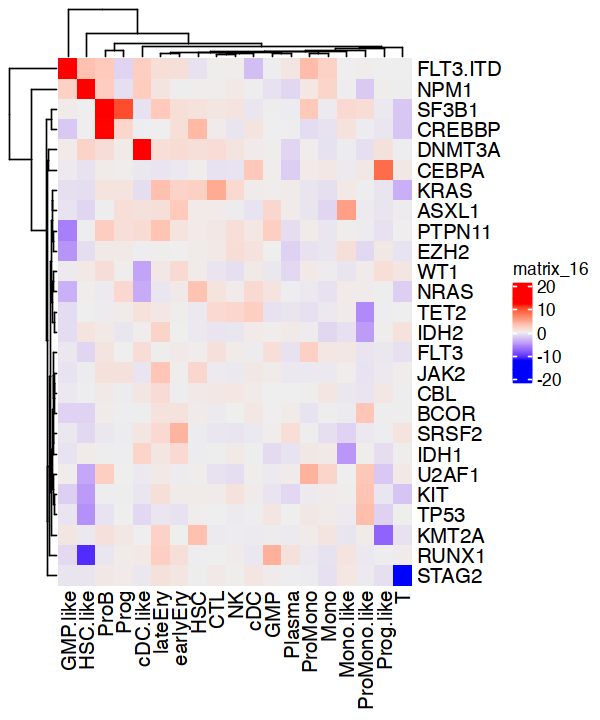

In [281]:
rownames(matrix_p) = colnames(mut.data_) ; colnames(matrix_p) = celltype_names ; 
options(repr.plot.width=5, repr.plot.height=6)
Heatmap(-log10(matrix_p)*sign(matrix_t))

The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.



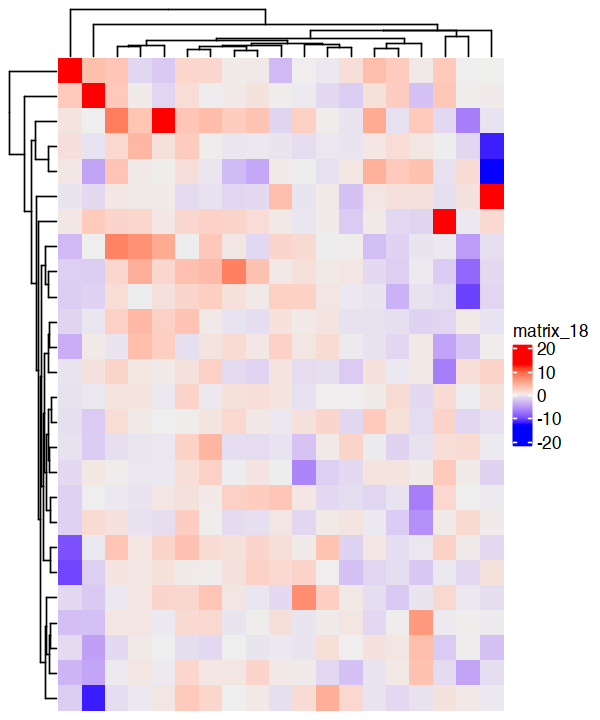

In [294]:
rownames(matrix_p) = colnames(mut.data_) ; colnames(matrix_p) = celltype_names ; 
h <- Heatmap(matrix_t)
col_order_ = column_order(h) ; row_order_ = row_order(h)
melt_mat = cbind(melt(matrix_p), melt(matrix_t))[,c(1,2,3,6)]
colnames(melt_mat) = c('mutation', 'celltype', 'p-value', 'size effect')
melt_mat$score = -log10(melt_mat$`p-value`)*sign(melt_mat$`size effect`)
melt_mat$size = abs(melt_mat$`size effect`)
melt_mat$mutation = factor(melt_mat$mutation, levels=unique(melt_mat$mutation)[row_order_])
melt_mat$celltype = factor(melt_mat$celltype, levels=unique(melt_mat$celltype)[col_order_])
melt_mat$score[melt_mat$score > 10] = 10
melt_mat$score[melt_mat$score < -10] = -10
options(repr.plot.width=6, repr.plot.height=3.7)
g <- ggplot(melt_mat, aes(x=mutation, y=celltype, color=score, size=size)) + geom_point() +
    scale_colour_gradient2(low = 'cornflowerblue', mid='white', high='red', midpoint = 0, name ='significance') + 
    scale_size_continuous(range = c(0, 4.5), name = 'size effect') +
    theme_classic() + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) 
pdf(paste0('results/fig5/mutation_fig/', this_drug, '_mut_vs_celltype_heatmap.pdf'), width=6, height=3.7) ; print(g) ; dev.ofF()

In [273]:
genes_ = gsub('\\.ITD','',colnames(mut.data_))[gsub('\\.ITD','',colnames(mut.data_)) %in% rownames(climb_out$expr.overall)]

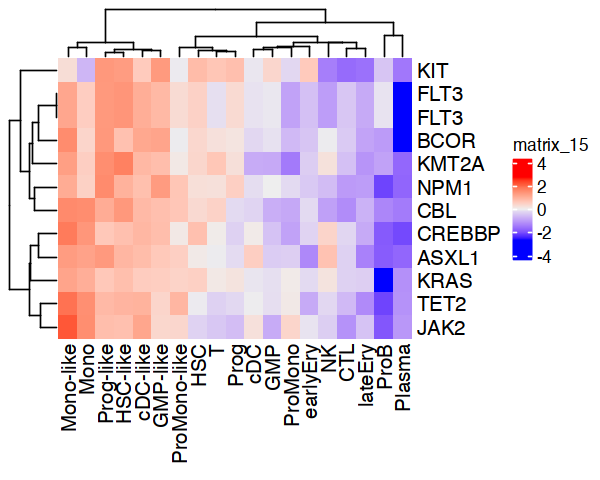

In [280]:
options(repr.plot.width=5, repr.plot.height=4)
Heatmap(t(scale(t(log2(climb_out$expr.overall[genes_,]+1)))))

A-674563

The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.

ABT-737

AT7519

The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.

AZD1480

The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.

Afatinib

Alisertib

Axitinib

The automatically generated colors map fro

LY-333531

Lapatinib

The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.

Lenalidomide

Lenvatinib

Linifanib

Lovastatin

MGCD-265

MK-2206

MLN8054

The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.

Masitinib

The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.


Volasertib

XAV-939



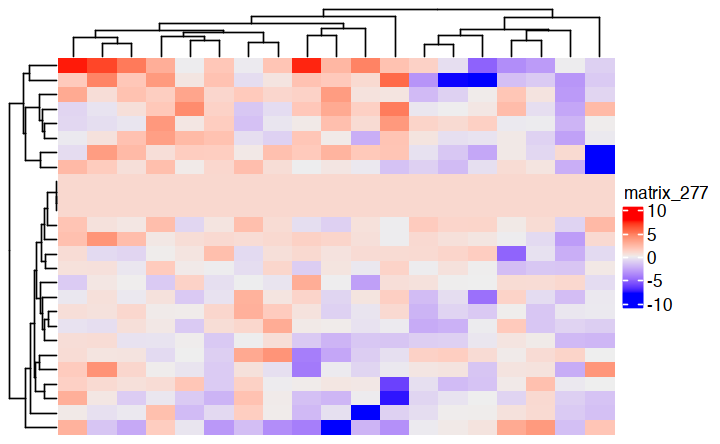

In [390]:
list_mat_p = list() ; list_mat_t = list() ; list_melt = list()
for(d in 1:length(list_files)){
    PI_mat = as.matrix(read.csv(paste0('results/fig5/tab_all_drugs/',list_files[[d]]), row.names='X'))
    mut.data_ = mut.data[rownames(PI_mat),]
    this_drug = gsub('\\ .csv','',gsub('PI_ ','',list_files[[d]]))
    message(this_drug)
    matrix_t = matrix(0, nrow=dim(mut.data_)[2], ncol=19)
    matrix_p = matrix(0, nrow=dim(mut.data_)[2], ncol=19)
    for(m in 1:dim(mut.data_)[2]){
        for(k in 1:19){
            if(sum(mut.data_[,m] == 1) < 3 | sum(mut.data_[,m] == 0) < 3){
                matrix_t[m,k] = 1
                matrix_p[m,k] = 1
            } else if (sum(mut.data_[,m] == 1) >= 3 & sum(mut.data_[,m] == 0) >= 3) {
                matrix_t[m,k] = num(t.test(PI_mat[,k][mut.data_[,m] == 1], PI_mat[,k][mut.data_[,m] == 0])$statistic)
                matrix_p[m,k] = num(t.test(PI_mat[,k][mut.data_[,m] == 1], PI_mat[,k][mut.data_[,m] == 0])$p.value)
            } else {
                matrix_t[m,k] = 1
                matrix_p[m,k] = 1
            }
        }  
    }
    rownames(matrix_p) = colnames(mut.data_) ; colnames(matrix_p) = celltype_names ; 
    list_mat_p[[d]] = matrix_p ; list_mat_t[[d]] = matrix_t
    h <- Heatmap(matrix_t)
    h <- draw(h)
    col_order_ = column_order(h) ; row_order_ = row_order(h)
    melt_mat = cbind(melt(matrix_p), melt(matrix_t))[,c(1,2,3,6)]
    colnames(melt_mat) = c('mutation', 'celltype', 'p-value', 'size effect')
    melt_mat$score = -log10(melt_mat$`p-value`)*sign(melt_mat$`size effect`)
    melt_mat$size = abs(melt_mat$`size effect`)
    melt_mat$mutation = factor(melt_mat$mutation, levels=unique(melt_mat$mutation)[row_order_])
    melt_mat$celltype = factor(melt_mat$celltype, levels=unique(melt_mat$celltype)[col_order_])
    melt_mat$score[melt_mat$score > 10] = 10
    melt_mat$score[melt_mat$score < -10] = -10
    list_melt[[d]] = melt_mat
    #options(repr.plot.width=6, repr.plot.height=3.7)
    #g <- ggplot(melt_mat, aes(x=mutation, y=celltype, color=score, size=size)) + geom_point() +
    #    scale_colour_gradient2(low = 'cornflowerblue', mid='white', high='red', midpoint = 0, name ='significance') + 
    #    scale_size_continuous(range = c(0, 4.5), name = 'size effect') +
    #    theme_classic() + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) 
    #pdf(paste0('results/fig5/mutation_fig/', this_drug, '_mut_vs_celltype_heatmap.pdf'), width=6, height=3.7) ; print(g) ; dev.off()
}

### Look at the enrichment of cell-type proportions in +/- patients. Is our finding simply a reflection of it ?

In [364]:
climb_prop = climb_out$props

In [366]:
rownames(climb_prop) = colnames(bulk.es)

In [367]:
mut.data_ = mut.data[rownames(climb_prop),]
mut.data_

,FLT3.ITD,NPM1,ASXL1,BCOR,CBL,CEBPA,CREBBP,DNMT3A,EZH2,FLT3,⋯,NRAS,PTPN11,RUNX1,SF3B1,SRSF2,STAG2,TET2,TP53,U2AF1,WT1
12-00023,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
12-00051,1,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
12-00066,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
12-00150,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
12-00211,0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
12-00258,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
12-00294,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
12-00372,1,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
12-00423,0,0,0,0,0,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
12-00426,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [368]:
matrix_t = matrix(0, nrow=dim(mut.data_)[2], ncol=19)
matrix_p = matrix(0, nrow=dim(mut.data_)[2], ncol=19)
for(m in 1:dim(mut.data_)[2]){
    for(k in 1:19){
        if(sum(mut.data_[,m] == 1) < 2 | sum(mut.data_[,m] == 0) < 2){
            matrix_t[m,k] = 1
            matrix_p[m,k] = 1
        } else {
            matrix_t[m,k] = num(t.test(climb_prop[,k][mut.data_[,m] == 1], climb_prop[,k][mut.data_[,m] == 0])$statistic)
            matrix_p[m,k] = num(t.test(climb_prop[,k][mut.data_[,m] == 1], climb_prop[,k][mut.data_[,m] == 0])$p.value)
        }
    }
    
}   

Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); column_order(ht)`.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”


pdf 
  2

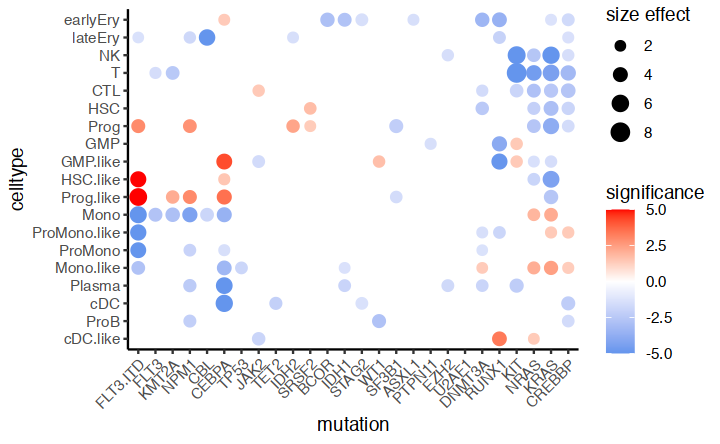

In [374]:
rownames(matrix_p) = colnames(mut.data_) ; colnames(matrix_p) = celltype_names ; 
h <- Heatmap(matrix_t)
col_order_ = column_order(h) ; row_order_ = row_order(h)
melt_mat = cbind(melt(matrix_p), melt(matrix_t))[,c(1,2,3,6)]
colnames(melt_mat) = c('mutation', 'celltype', 'p-value', 'size effect')
melt_mat$score = -log10(melt_mat$`p-value`)*sign(melt_mat$`size effect`)
melt_mat$size = abs(melt_mat$`size effect`)
melt_mat$mutation = factor(melt_mat$mutation, levels=unique(melt_mat$mutation)[row_order_])
melt_mat$celltype = factor(melt_mat$celltype, levels=unique(melt_mat$celltype)[col_order_])
melt_mat$score[melt_mat$score > 5] = 5
melt_mat$score[melt_mat$score < -5] = -5
melt_mat$score[abs(melt_mat$score) < 1.3] = 0
options(repr.plot.width=6, repr.plot.height=3.7)
g <- ggplot(melt_mat, aes(x=mutation, y=celltype, color=score, size=size)) + geom_point() +
    scale_colour_gradient2(low = 'cornflowerblue', mid='white', high='red', midpoint = 0, name ='significance') + 
    scale_size_continuous(range = c(0, 4.5), name = 'size effect') +
    theme_classic() + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
pdf('results/fig5/mutation_vs_climb_prop_enrichment.pdf', width=6, height=3.7) ; g; dev.off()
g

## Average over all drugs

In [425]:
all_mat_p = do.call(cbind, list_mat_p)
mean_mat_p = aggregate(t(all_mat_p), list(colnames(all_mat_p)), function(x) mean(-log10(x)))
rownames(mean_mat_p) = mean_mat_p[,1] ; mean_mat_p = mean_mat_p[,-1]

In [426]:
all_mat_t = do.call(cbind, list_mat_t)
mean_mat_t = aggregate(t(all_mat_t), list(colnames(all_mat_p)), mean)
rownames(mean_mat_t) = mean_mat_t[,1] ; mean_mat_t = mean_mat_t[,-1]

In [427]:
colnames(mean_mat_t) = colnames(mean_mat_p)

In [428]:
mean_mat_p$celltype = rownames(mean_mat_p)
mean_mat_t$celltype = rownames(mean_mat_t)
melt_mat = cbind(melt(mean_mat_p), melt(mean_mat_t))[,c(1,2,3,6)]

Using celltype as id variables

Using celltype as id variables



Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“Note: not all columns in the data frame are numeric. The data frame
will be converted into a character matrix.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); column_order(ht)`.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”


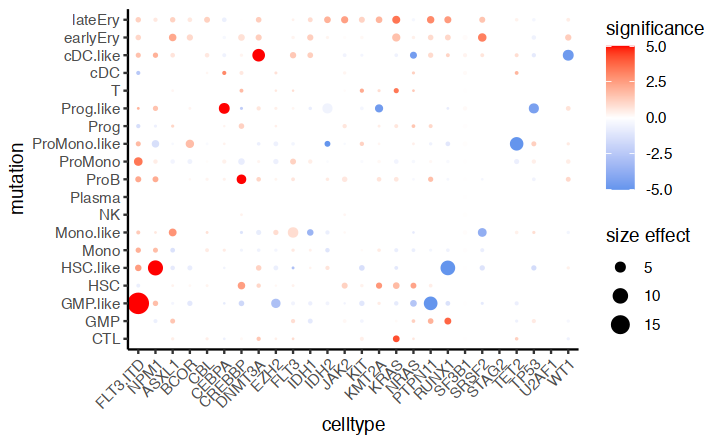

In [430]:
h <- Heatmap(mean_mat_t)
col_order_ = column_order(h) ; row_order_ = row_order(h)
colnames(melt_mat) = c('mutation', 'celltype', 'p-value', 'size effect')
melt_mat$score = melt_mat$`p-value`*sign(melt_mat$`size effect`)
melt_mat$size = abs(melt_mat$`size effect`)
melt_mat$mutation = factor(melt_mat$mutation, levels=unique(melt_mat$mutation)[row_order_])
melt_mat$celltype = factor(melt_mat$celltype, levels=unique(melt_mat$celltype)[col_order_])
melt_mat$score[melt_mat$score > 5] = 5
melt_mat$score[melt_mat$score < -5] = -5
#melt_mat$score[abs(melt_mat$score) < 1.3] = 0
options(repr.plot.width=6, repr.plot.height=3.7)
g <- ggplot(melt_mat, aes(y=mutation, x=celltype, color=score, size=size)) + geom_point() +
    scale_colour_gradient2(low = 'cornflowerblue', mid='white', high='red', midpoint = 0, name ='significance') + 
    scale_size_continuous(range = c(-1, 5), name = 'size effect') +
    theme_classic() + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
#pdf('results/fig5/mutation_vs_climb_prop_enrichment.pdf', width=6, height=3.7) ; g; dev.off()
g